<a href="https://colab.research.google.com/github/hrumst/ML/blob/master/submission_9_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%config IPComplater.greedy = True

In [2]:
from google.colab import drive
drive.mount('./DRIVE', force_remount=True)

Mounted at ./DRIVE


In [3]:
!pip show keras

Name: Keras
Version: 2.2.5
Summary: Deep Learning for humans
Home-page: https://github.com/keras-team/keras
Author: Francois Chollet
Author-email: francois.chollet@gmail.com
License: MIT
Location: /usr/local/lib/python3.6/dist-packages
Requires: numpy, pyyaml, h5py, scipy, six, keras-applications, keras-preprocessing
Required-by: 


In [0]:
!pip freeze > requirements.txt

In [5]:
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# keras
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, BatchNormalization, Bidirectional, Lambda, Concatenate
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.optimizers import Adam, Adamax
from keras.callbacks import ModelCheckpoint

# plt
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

DATASET_PATH = './DRIVE/My Drive/colab_data/Test_classification/'

import os
for dirname, _, filenames in os.walk(DATASET_PATH):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Using TensorFlow backend.


./DRIVE/My Drive/colab_data/Test_classification/train.csv
./DRIVE/My Drive/colab_data/Test_classification/test.csv


In [0]:
# seed values
SEED = 42
random.seed = SEED
np.random.seed(seed=SEED)

# SETUP
В setup выносим основные настройки

In [0]:
# MODEL
BATCH_SIZE  = 128
EPOCH       = 10
VAL_SPLIT   = 0.15  #15%

# TOKENIZER
# The maximum number of words to be used. (most frequent)
TEXT_MAX_WORDS = 10000
NAME_MAX_WORDS = 1000
# Max number of words in each complaint.
MAX_TEXT_SEQUENCE_LENGTH = 170
MAX_NAME_SEQUENCE_LENGTH = 5

DATA_PATH = DATASET_PATH

# Pre-Trained Embedding

In [6]:
!unzip './DRIVE/My Drive/colab_data/text/glove.6B.zip' -d './DRIVE/My Drive/colab_data/text/glove.6B'

Archive:  ./DRIVE/My Drive/colab_data/text/glove.6B.zip
  inflating: ./DRIVE/My Drive/colab_data/text/glove.6B/glove.6B.50d.txt  
  inflating: ./DRIVE/My Drive/colab_data/text/glove.6B/glove.6B.100d.txt  
  inflating: ./DRIVE/My Drive/colab_data/text/glove.6B/glove.6B.200d.txt  
  inflating: ./DRIVE/My Drive/colab_data/text/glove.6B/glove.6B.300d.txt  


In [12]:
!unzip './DRIVE/My Drive/colab_data/text/20_newsgroup.zip' -d './DRIVE/My Drive/colab_data/text/20_newsgroup'


Archive:  ./DRIVE/My Drive/colab_data/text/20_newsgroup.zip
   creating: ./DRIVE/My Drive/colab_data/text/20_newsgroup/20_newsgroup/
   creating: ./DRIVE/My Drive/colab_data/text/20_newsgroup/20_newsgroup/talk.politics.mideast/
  inflating: ./DRIVE/My Drive/colab_data/text/20_newsgroup/20_newsgroup/talk.politics.mideast/75895  
   creating: ./DRIVE/My Drive/colab_data/text/20_newsgroup/__MACOSX/
   creating: ./DRIVE/My Drive/colab_data/text/20_newsgroup/__MACOSX/20_newsgroup/
   creating: ./DRIVE/My Drive/colab_data/text/20_newsgroup/__MACOSX/20_newsgroup/talk.politics.mideast/
  inflating: ./DRIVE/My Drive/colab_data/text/20_newsgroup/__MACOSX/20_newsgroup/talk.politics.mideast/._75895  
  inflating: ./DRIVE/My Drive/colab_data/text/20_newsgroup/20_newsgroup/talk.politics.mideast/76248  
  inflating: ./DRIVE/My Drive/colab_data/text/20_newsgroup/__MACOSX/20_newsgroup/talk.politics.mideast/._76248  
  inflating: ./DRIVE/My Drive/colab_data/text/20_newsgroup/20_newsgroup/talk.politics.m

KeyboardInterrupt: ignored

In [0]:
!rm -rf './DRIVE/My Drive/colab_data/text/20_newsgroup/__MACOSX/*'

In [8]:
PRETRAINED_EMBEDDING_DATA_PATH = './DRIVE/My Drive/colab_data/text/glove.6B/'

print('Indexing word vectors.')

embeddings_index = {}
with open(PRETRAINED_EMBEDDING_DATA_PATH + 'glove.6B.100d.txt') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))



Indexing word vectors.


In [0]:
# second, prepare text samples and their labels
print('Processing text dataset')

texts = []  # list of text samples
labels_index = {}  # dictionary mapping label name to numeric id
labels = []  # list of label ids
for name in sorted(os.listdir(TEXT_DATA_DIR)):
    path = os.path.join(TEXT_DATA_DIR, name)
    if os.path.isdir(path):
        label_id = len(labels_index)
        labels_index[name] = label_id
        for fname in sorted(os.listdir(path)):
            if fname.isdigit():
                fpath = os.path.join(path, fname)
                args = {} if sys.version_info < (3,) else {'encoding': 'latin-1'}
                with open(fpath, **args) as f:
                    t = f.read()
                    i = t.find('\n\n')  # skip header
                    if 0 < i:
                        t = t[i:]
                    texts.append(t)
                labels.append(label_id)

print('Found %s texts.' % len(texts))

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

In [0]:
# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

# Data
#### TRAIN

In [0]:
train_df = pd.read_csv(DATA_PATH+'train.csv',)

In [9]:
train_df.head()

,name,genre,text
0,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54214 entries, 0 to 54213
Data columns (total 3 columns):
name     54214 non-null object
genre    54214 non-null object
text     54214 non-null object
dtypes: object(3)
memory usage: 1.2+ MB


Text(0, 0.5, 'Counts')

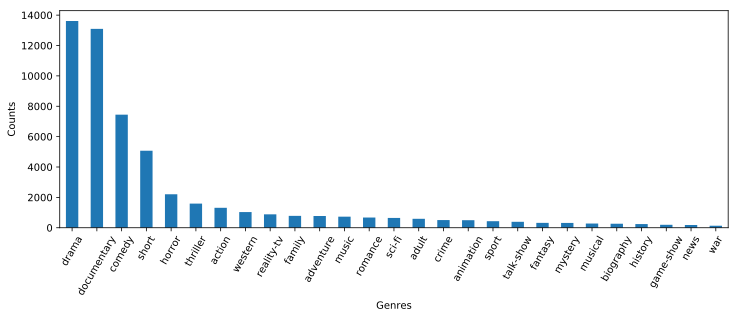

In [11]:
train_df.genre.value_counts().plot(kind='bar',figsize=(12,4),fontsize=10)
plt.xticks(rotation=60)
plt.xlabel("Genres",fontsize=10)
plt.ylabel("Counts",fontsize=10)

### TEST

In [12]:
test_df = pd.read_csv(DATA_PATH+'test.csv')
test_df.head()

,name,text
0,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,Er nu zhai (1955),Before he was known internationally as a mart...


### Target

In [13]:
Y = pd.get_dummies(train_df.genre)
CLASS_NUM = Y.shape[1]
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (54214, 27)


In [0]:
Y.head()

,action,adult,adventure,animation,biography,comedy,crime,documentary,drama,family,fantasy,game-show,history,horror,music,musical,mystery,news,reality-tv,romance,sci-fi,short,sport,talk-show,thriller,war,western
0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Preprocessing

### Clean Data

In [83]:
import re
regex = re.compile(r"\(.{4}\)", re.IGNORECASE)
train_df['name'] = train_df['name'].apply(lambda x : regex.sub("", x))
test_df['name'] = test_df['name'].apply(lambda x : regex.sub("", x))

train_df.head()

,name,genre,text
0,Oscar et la dame rose,drama,Listening in to a conversation between his do...
1,Cupid,thriller,A brother and sister with a past incestuous r...
2,"Young, Wild and Wonderful",adult,As the bus empties the students for their fie...
3,The Secret Sin,drama,To help their unemployed father make ends mee...
4,The Unrecovered,drama,The film's title refers not only to the un-re...


### Tokenize data and convert the text to sequences

Токенизация — это самый первый шаг при обработке текста. Заключается в разбиении (разделении) длинных строк текста в более мелкие: абзацы делим на предложения, предложения на слова. В итоге мы получаем некий словарь, который позволит превратить наш текст в векторное представление для сети.

в Keras есть замечательная утидлита [Tokenizer](https://keras.io/preprocessing/text/) которая позволяет сделать всю предобработку буквально в пару строчек кода! 
Больше примеров в коде можно найти тут:  
https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/

In [0]:
# для построения словаря мы используем весь текст
all_text = train_df.text.append(test_df.text, ignore_index=True)

In [20]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(all_text)

CPU times: user 10.5 s, sys: 36.8 ms, total: 10.6 s
Wall time: 10.6 s


теперь переведем наш текст в вектор

In [32]:
%%time
text_sequences = tokenize.texts_to_sequences(train_df['text'])
text_sequences_matrix = sequence.pad_sequences(text_sequences, maxlen=MAX_TEXT_SEQUENCE_LENGTH)
print(text_sequences_matrix.shape)

(54214, 170)
CPU times: user 4.78 s, sys: 32.1 ms, total: 4.81 s
Wall time: 4.83 s


In [40]:
%%time
name_sequences = tokenize.texts_to_sequences(train_df['name'])
name_sequences_matrix = sequence.pad_sequences(name_sequences, maxlen=MAX_NAME_SEQUENCE_LENGTH)
print(name_sequences_matrix.shape)

(54214, 5)
CPU times: user 1.14 s, sys: 4.81 ms, total: 1.14 s
Wall time: 1.15 s


In [28]:
max_seq_matrix_len = 0
for sm in name_sequences:
    if len(sm) > max_seq_matrix_len:
        max_seq_matrix_len = len(sm)
max_seq_matrix_len

37

In [41]:
# вот так теперь выглядит наш текст
print(len(text_sequences_matrix))
print(train_df['text'][1])
print(text_sequences_matrix[1])

# вот так теперь выглядит наш неминг
print(len(name_sequences_matrix))
print(train_df['name'][3])
print(name_sequences_matrix[3])

54214
 A brother and sister with a past incestuous relationship have a current murderous relationship. He murders the women who reject him and she murders the women who get too close to him.
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0

# Model
Архитектура сети достаточно простая. Попробуйте самостоятельно поиграться с гиперпараметрами сети и составом слоев. 


In [0]:
from keras.callbacks import *

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [0]:
def RNN_v1():
    inputs = Input(name='inputs',shape=[MAX_SEQUENCE_LENGTH])
    layer = Embedding(TEXT_MAX_WORDS,50,input_length=MAX_SEQUENCE_LENGTH)(inputs)
    layer = LSTM(100)(layer)
    layer = Dense(256, activation='relu', name='FC1')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(CLASS_NUM, activation='sigmoid', name='out_layer')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

def RNN_v2():
    inputs = Input(name='inputs',shape=[MAX_SEQUENCE_LENGTH])
    layer = Embedding(TEXT_MAX_WORDS,50,input_length=MAX_SEQUENCE_LENGTH)(inputs)
    layer = LSTM(64, return_sequences=True)(layer)
    layer = BatchNormalization()(layer)
    layer = LSTM(64, return_sequences=False, dropout=.5, recurrent_dropout=.2)(layer)
    layer = BatchNormalization()(layer)
    layer = Dense(256, activation='relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(CLASS_NUM, activation='sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

def RNN_v3():
    name_input = Input(name='name_input',shape=[MAX_NAME_SEQUENCE_LENGTH])
    name_layer = Embedding(TEXT_MAX_WORDS, 100, input_length=MAX_TEXT_SEQUENCE_LENGTH)(name_input)
    name_layer = BatchNormalization(name='B_1.1')(name_layer)
    name_layer = LSTM(64, return_sequences=True)(name_layer)
    name_layer = LSTM(64, return_sequences=False, dropout=.25, recurrent_dropout=.25, name='Name-LSTM-out')(name_layer)

    text_input = Input(name='text_input',shape=[MAX_TEXT_SEQUENCE_LENGTH])
    text_layer = Embedding(NAME_MAX_WORDS, 100, input_length=MAX_NAME_SEQUENCE_LENGTH)(text_input)
    text_layer = BatchNormalization(name='B_1.2')(text_layer)
    text_layer = LSTM(64, return_sequences=True)(text_layer)
    text_layer = LSTM(64, return_sequences=False, dropout=.25, recurrent_dropout=.25, name='Text-LSTM-out')(text_layer)

    ultimate_layer = Concatenate()([text_layer, name_layer])
    ultimate_layer = BatchNormalization(name='B_2')(ultimate_layer)
    ultimate_layer = Dense(256, activation='elu')(ultimate_layer)
    ultimate_layer = Dense(CLASS_NUM, activation='sigmoid')(ultimate_layer)

    model = Model(inputs=[name_input, text_input], outputs=ultimate_layer)
    return model


In [68]:
model = RNN_v3()
model.summary()
model.compile(loss='categorical_crossentropy', optimizer=Adamax(lr=1e-4), metrics=['accuracy'])
cycle_lr = CyclicLR(base_lr=5e-3, max_lr=1e-5, step_size=text_sequences_matrix.shape[0], mode='exp_range')
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_acc'] , verbose = 1  , mode = 'max')
cbs = [cycle_lr, checkpoint]

inputs = [text_sequences_matrix, name_sequences_matrix]
history = model.fit(inputs, Y, batch_size=BATCH_SIZE, epochs=10, validation_split=VAL_SPLIT, callbacks=cbs)

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         (None, 5)            0                                            
__________________________________________________________________________________________________
name_input (InputLayer)         (None, 170)          0                                            
__________________________________________________________________________________________________
embedding_19 (Embedding)        (None, 5, 100)       100000      text_input[0][0]                 
__________________________________________________________________________________________________
embedding_18 (Embedding)        (None, 170, 100)     1000000     name_input[0][0]                 
____________________________________________________________________________________________

KeyboardInterrupt: ignored

In [0]:
model.save('keras_nlp_lstm.h5')
model.load_weights('best_model.hdf5')

NameError: ignored

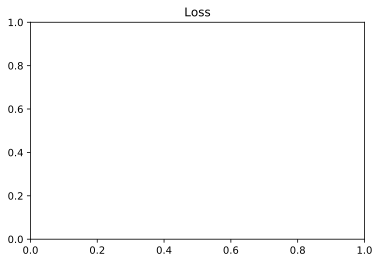

In [71]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.show();

In [0]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.show();

# Submission

In [89]:
text_test_sequences = tokenize.texts_to_sequences(test_df['text'])
text_test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=MAX_TEXT_SEQUENCE_LENGTH)

name_test_sequences = tokenize.texts_to_sequences(test_df['name'])
name_test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=MAX_NAME_SEQUENCE_LENGTH)

text_test_sequences_matrix.shape, name_test_sequences_matrix.shape

((54200, 170), (54200, 5))

In [91]:
%%time
predict_proba = model.predict([text_test_sequences_matrix, name_test_sequences_matrix])

CPU times: user 11min 8s, sys: 1min 20s, total: 12min 29s
Wall time: 7min 48s


In [76]:
# на соревнованиях всегда сохраняйте predict_proba, чтоб потом можно было построить ансамбль решений
predict_proba = pd.DataFrame(predict_proba, columns=Y.columns)
predict_proba.to_csv('predict_proba.csv', index=False)
predict_proba.head()

NameError: ignored

In [77]:
predict_genre = Y.columns[np.argmax(predict_proba.values, axis=1)]

NameError: ignored

In [78]:
submission = pd.DataFrame({'id':range(1, len(predict_genre)+1), 
                           'genre':predict_genre}, 
                          columns=['id', 'genre'])

submission.to_csv('submission.csv', index=False)
submission.head()

NameError: ignored

Готово!

## Что можно сделать, чтоб улучшить результат:
* Подобрать LR, optimizer, loss
* Поиграться с архитектурой
* Подобрать другие переменные (MAX_WORDS, MAX_SEQUENCE_LENGTH, батч и тп)
* Добавить политику обучения
* Добавить в обучение название фильма (для pro: попробуйте это сделать через concatenate слой)
* Попробовать уже предобученные Векторизаторы (GLOVE, W2V и тд)
* Попробовать уже предобученные модели (BERT, TRANFORMER и тд)
* Построить ансамбль из разных архитектур